# Pairwise causal discovery 

### Life expectancy vs Health expenditure

Goals: 
- analyze life expectancy in relation to health expenditure
- evaluate pairwise methods from causal discovery toolbox

Data Sources:
- Life expectancy: OurWorldInData, https://ourworldindata.org/grapher/life-expectancy?time=..&country=~OWID_WRL
- Health expenditure: WHO's Global Health Expenditure Database (GHED), http://apps.who.int/nha/database/Home/IndicatorsDownload/en
  
Libraries
- causal inference: `cdt`
- visualization: `matplotlib`, `seaborn`
- other libraries: `pandas`, `numpy`

### Step 1: Load and prepare data
#### 1.1.- Merge data from `life-expectancy.csv` and `health-expenditure.csv`

In [1]:
import pandas as pd
df_y = pd.read_csv("data/life-expectancy.csv")
df_x = pd.read_csv('data/health_expenditure.csv', sep='|')
df_x = df_x[df_x["Indicator Code"] == 'sha11.HF']
df_x.columns = ['Entity', 'Code', 'Indicator Code','Year', 'Health expenditure']
df_xy = df_x.merge(df_y)
df_xy.info()
#df_xy.dropna()
#df_x

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050 entries, 0 to 3049
Data columns (total 6 columns):
Entity                     3050 non-null object
Code                       3050 non-null object
Indicator Code             3050 non-null object
Year                       3050 non-null float64
Health expenditure         3050 non-null float64
Life expectancy (years)    3050 non-null float64
dtypes: float64(3), object(3)
memory usage: 166.8+ KB


### Step 2: Explore the data
#### 2.1.- Visualization

Histograms in diagonal. Scatterplot off diagonal

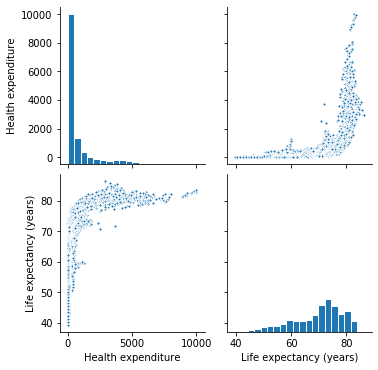

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.PairGrid(df_xy, vars=["Health expenditure", "Life expectancy (years)"])
g = g.map_diag(plt.hist, edgecolor="w", bins=20)
g = g.map_offdiag(plt.scatter, edgecolor="w", s=10)

According to the charts, it seems that health expenditure is associated with increase in life expectancy. Though it seems the relation is not linear. So let's assume life expectancy is associated with increase in logarithm of health expenditure. And compare correlations

#### 2.2.- Correlations. Linear vs log-transformed


In [3]:
import numpy as np
corr = np.corrcoef(df_xy['Life expectancy (years)'], df_xy['Health expenditure'])
print(corr)

[[1.         0.57565989]
 [0.57565989 1.        ]]


In [4]:
corr = np.corrcoef(df_xy['Life expectancy (years)'], np.log(df_xy['Health expenditure']))
print(corr)

[[1.         0.80981449]
 [0.80981449 1.        ]]


Our assumption make sense. Let's add to `df_xy` the new variable `health_expenditure_log` with the logarithmic transformation of Health expenditure. And visualize again histograms and relationships between variables

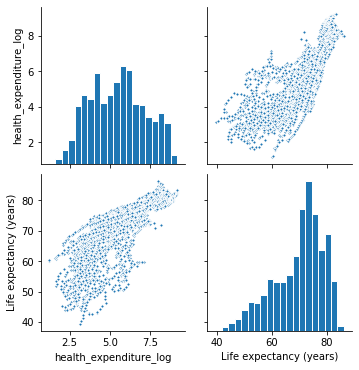

In [5]:
df_xy['health_expenditure_log'] = np.log(df_xy['Health expenditure'])
g = sns.PairGrid(df_xy, vars=["health_expenditure_log", "Life expectancy (years)"])
g = g.map_diag(plt.hist, edgecolor="w", bins=20)
g = g.map_offdiag(plt.scatter, edgecolor="w", s=10)

### Step 3: Pairwise causal discovery

#### 3.1.- Generate and plot undirected graph

- Model: `Glaso` (as `HSICLasso` gets `argmax of an empty sequence` error)
- Data: subset of 3 columns: `health_expenditure`, `health_expenditure_log` and `life_expectancy`

In [6]:
df = df_xy.loc[:,['Health expenditure', 'Life expectancy (years)', 'health_expenditure_log']]
df.columns = ['health_expenditure', 'life_expectancy', 'health_expenditure_log']
df.head()

,health_expenditure,life_expectancy,health_expenditure_log
0,444.939432,73.940,6.097938
1,497.096598,74.171,6.208784
2,512.317693,74.395,6.238945
3,569.649036,74.613,6.345020
4,547.871067,74.821,6.306040


No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


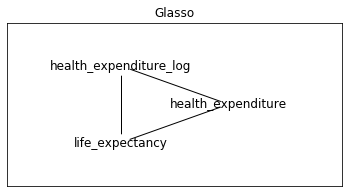

In [7]:
from cdt.independence.graph import HSICLasso,Glasso,DecisionTreeRegression

#obj = HSICLasso()
obj = Glasso()
ugraph = obj.predict(df)

import networkx as nx
import matplotlib.pyplot as plt
graph = ugraph

# Sort alphabetically, to keep same circular layout
sorted_graph = nx.Graph()
sorted_graph.add_edges_from(sorted(graph.edges()))
pos = nx.drawing.layout.circular_layout(sorted_graph)

plt.figure(0,figsize=(6,3)) 
nx.draw_networkx(sorted_graph,pos, node_color='#ffffff')
plt.title("Glasso")
plt.margins(1,0.5)
plt.show()

#### 3.2.- Plot directed graph

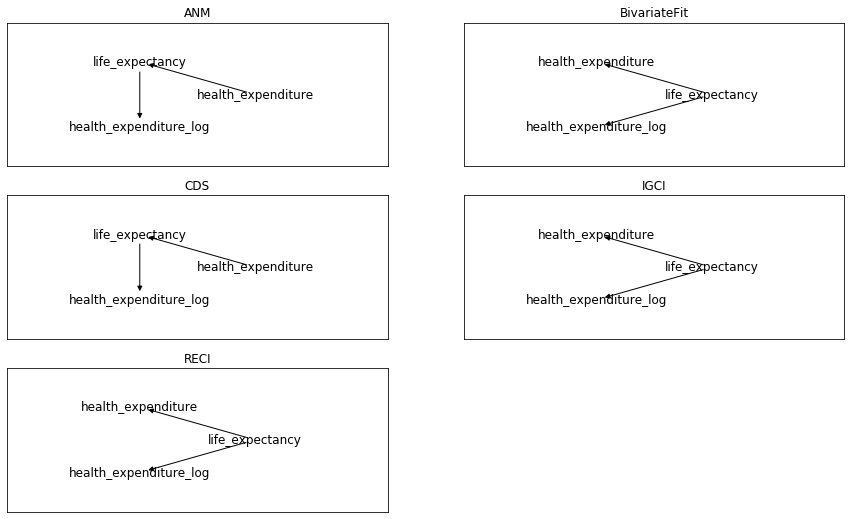

In [8]:
from cdt.causality.pairwise import *
def test_pairwise_model(mymodel,mycount):
    obj = mymodel()
    graph = obj.orient_graph(df, nx.DiGraph(ugraph))
    sorted_graph = nx.DiGraph()
    sorted_graph.add_edges_from(sorted(graph.edges()))
    pos = nx.drawing.layout.circular_layout(sorted_graph)

    #
    plt.subplot(3,2,mycount)
    nx.draw_networkx(sorted_graph,pos,node_color='#ffffff')
    plt.title(mymodel.__name__)
    plt.margins(1,0.5)
      
plt.figure(0,figsize=(15,9))

mycount = 1
for mymodel in [ANM,BivariateFit, CDS, IGCI, RECI]:
   
    test_pairwise_model(mymodel, mycount)
    mycount+=1
plt.show()

#### 3.3.- Analyze `CDS` method

In [9]:
def test_pairwise_cds_score(X, Y):
    obj = CDS()
    x = df_xy[X]
    y = df_xy[Y]
    mybool = obj.cds_score(x,y)<obj.cds_score(y,x)
    return mybool

COL_X = 'Health expenditure'
COL_Y = 'Life expectancy (years)'
myresult = test_pairwise_cds_score('Health expenditure', 'Life expectancy (years)')
print("'{}' -> '{}' seems {} according to cds_score".format(COL_X, COL_Y, myresult))

'Health expenditure' -> 'Life expectancy (years)' seems True according to cds_score


The `CDS` (*Conditional Distribution Similarity Statistic*)  measures the std. of the rescaled values of y (resp. x) after binning in the x (resp. y) direction. The lower the std. the more likely the pair to be x->y (resp. y->x). It is a single feature of the Jarfo model. See https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html#cds

Though it seems results depend much on the discretization or binning phase. And this discretization phase depends on 3 parameters: `ffactor`, `maxdev` and `minc`. 

As the [author explains]([https://github.com/jarfo/cause-effect/issues/1#issuecomment-724697472]):
 "*ffactor and maxdev controls the discretization (quantization) 
process (ffactor controls the resolution and maxdev the outliers).
minc is a threshold on the minimum number of samples for a given x discrete value or label. A x value that appears less than minc times is ignored*"

Default values are `ffactor`=2, `maxdev`=3, `minc`=12

First of all, let's understand the implications of default values for our variables

#### 3.3.1.- Influence of CDS parameters in discretization errors

In [10]:
FFACTOR = 2
MAXDEV = 3

def discretized_values(x, ffactor, maxdev):
    if len(set(x)) > (2*ffactor*maxdev+1):
        vmax =  ffactor*maxdev
        vmin = -ffactor*maxdev
        return range(vmin, vmax+1)
    else:
        return sorted(list(set(x)))

x = df_xy['Health expenditure']
myrange = discretized_values(x, FFACTOR, MAXDEV)
print("x: {} different ({}) values are discretized in {} bins, on {}".format(len(set(x)),x.dtype,len(myrange),myrange))

y = df_xy['Life expectancy (years)']
myrange = discretized_values(y, FFACTOR, MAXDEV)
print("y: {} different ({}) values are discretized in {} bins, on {}".format(len(set(y)),y.dtype,len(myrange),myrange))


x: 3050 different (float64) values are discretized in 13 bins, on range(-6, 7)
y: 2887 different (float64) values are discretized in 13 bins, on range(-6, 7)


Health expenditure: SMAPE error between discrete filtered sequence and scaled original is 23.9%

Life expectancy (years): SMAPE error between discrete filtered sequence and scaled original is 12.6%



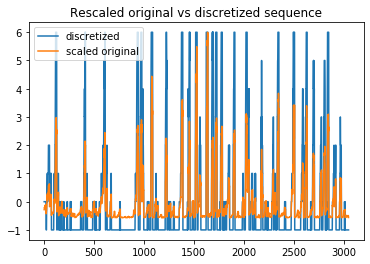

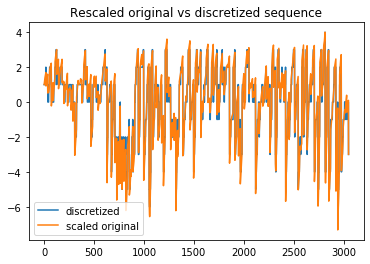

In [11]:
from collections import Counter

def discretized_sequence(x, ffactor=2, maxdev=3, norm=True):
    if len(set(x)) > len(range(-ffactor*maxdev,ffactor*maxdev+1)):
        
        x = (x - np.mean(x))/np.std(x)
        xf = x[abs(x) < maxdev]
        x = (x - np.mean(xf))/np.std(xf)
        x = np.round(x*ffactor)
        vmax =  ffactor*maxdev
        vmin = -ffactor*maxdev
        x[x > vmax] = vmax
        x[x < vmin] = vmin
    return x

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 0.5*np.mean(abs(y_true-y_pred)/(abs(y_true)+abs(y_pred)))

def discretized_sequence_minc(xd,minc=12):
    xdf= xd.where(~xd.isin([x for x, count in Counter(xd).items() if count < minc]))
    ratio_nulls = len(xdf[xdf.isnull()])/len(xdf)
    
    # To ignore effect of MINC filtering unless discarded values exceed 5% of samples
    if ratio_nulls > 0.05:
        raise ValueError('Too much filtered values ({}%) because count <  MINC={}'.format(100*ratio_nulls, minc))
    
    xdf[np.isnan(xdf)]=max(xd)
    return xdf

def rescaled_sequence(x, amplitude=1):
    xs =amplitude*(x - np.mean(x))/(max(x) -np.mean(x))
    return xs

def explore_discretization_errors(col, ffactor=2, maxdev=3, minc=12):
    x = df_xy[col]
  
    xd = discretized_sequence(x, ffactor=ffactor, maxdev=maxdev)
    plt.figure()
    plt.plot(xd, label="discretized")
   
    xs =rescaled_sequence(x,max(xd))
    
    plt.plot(xs, label="scaled original")
    
    plt.legend()
    plt.title('Rescaled original vs discretized sequence')

    xdf= discretized_sequence_minc(xd,minc=minc)

    smape = symmetric_mean_absolute_percentage_error(xs,xdf)
    print("{}: SMAPE error between discrete filtered sequence and scaled original is {:.1f}%\n".format(col, 100*smape))

explore_discretization_errors('Health expenditure')
explore_discretization_errors('Life expectancy (years)')

With default parameters, discretization distort mainly 'Health expenditure'. Let's see what happens if we double both resolution and limit for outliers with `ffactor`= 4, `maxdev`=6:

Health expenditure: SMAPE error between discrete filtered sequence and scaled original is 6.2%

Life expectancy (years): SMAPE error between discrete filtered sequence and scaled original is 7.3%



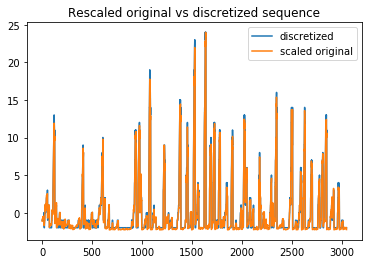

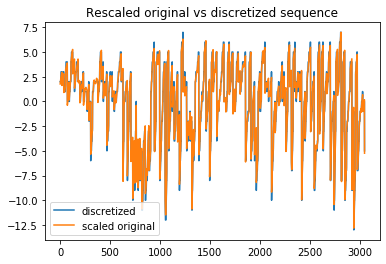

In [12]:
explore_discretization_errors('Health expenditure', ffactor=4, maxdev=6)
explore_discretization_errors('Life expectancy (years)', ffactor=4, maxdev=6)

Discretization distorsion (*Symmetric Mean Average Percentage Error*) reduces for both variables below 8%.

By generating a meshgrid, with `ffactor` and `maxdev` from 1 to 10, it is possible to visualize the discretization error:

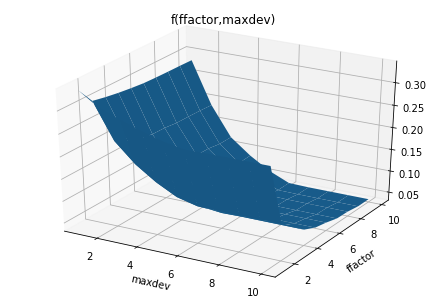

In [13]:
def test_discretization_error_grid_params(X, Y, f_range, d_range, minc=12):
    aresult = np.empty((len(f_range),len(d_range)))
    for f in f_range:
        for d in d_range:
            nbins = len(range(-f*d,f*d+1))
            
            x = df_xy[X]
     
            xd = discretized_sequence(x, ffactor=f, maxdev=d)
            xdf = discretized_sequence_minc(xd,minc=minc)
            xs = rescaled_sequence(x,amplitude=max(xd))
            
            mape_x = symmetric_mean_absolute_percentage_error(xdf,xs)
  
            if (np.isnan(mape_x)):
                print("x: f {} and d {}, so nbins={}".format(f,d,nbins))
            
            y = df_xy[Y]
           
            yd = discretized_sequence(y, ffactor=f, maxdev=d)
            ydf = discretized_sequence_minc(yd,minc=minc)
            ys = rescaled_sequence(y,amplitude=max(yd))
            
            mape_y = symmetric_mean_absolute_percentage_error(ydf,ys)

            if (np.isnan(mape_y)):
                print("y: f {} and d {}, so nbins={}".format(f,d,nbins))
            
            aresult[np.where(f_range==f)[0][0]][np.where(d_range==d)[0][0]] = (mape_x + mape_y)/2
    
    return aresult


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_meshgrid(f_range,d_range,nu,title='f(ffactor,maxdev)'):
    F,D = np.meshgrid(d_range,f_range, sparse=True)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(F, D, nu)
    plt.xlabel('maxdev')
    plt.ylabel('ffactor')
    plt.title(title)
    plt.show()


# default ffactor was 3. I make a grid from 1 to 10
F_RANGE = np.arange(1, 11, 1)

# default maxdev was 2. I make a grid from 2 to 10
D_RANGE = np.arange(1, 11, 1)    

error = test_discretization_error_grid_params('Health expenditure', 'Life expectancy (years)', F_RANGE, D_RANGE)
plot_meshgrid(F_RANGE,D_RANGE,error)

We can see, as expected, lower values of `ffactor` and `maxdev` generate increase discretization errors.

#### 3.3.2.- Sensitivity of `cds_score` and orientation estimations to `CDS` parameters

'Health expenditure'->'Life expectancy (years)' seems True 100/100=100% times according to cds_score


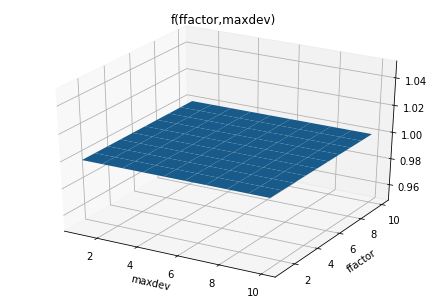

In [14]:
def test_pairwise_cds_score_grid_params(X, Y, f_range, d_range, minc=12):
    result = []
   
    mysize = (len(f_range),len(d_range))
    
    aresult = np.empty(mysize)
    for f in f_range:
        for d in d_range:
            x = df_xy[X]
            y = df_xy[Y]
            obj = CDS(ffactor=f, maxdev=d,minc=minc)
            mybool = obj.cds_score(x,y)<obj.cds_score(y,x)
            result.append(mybool)
            aresult[np.where(f_range==f)[0][0]][np.where(d_range==d)[0][0]] = mybool
    myres = 100*np.mean(result)
    print("'{}'->'{}' seems True {}/{}={:.0f}% times according to cds_score".format(X,Y,np.sum(result),len(result),myres))
   
    return aresult


cds_score = test_pairwise_cds_score_grid_params('Health expenditure', 'Life expectancy (years)', F_RANGE, D_RANGE, minc=12)
plot_meshgrid(F_RANGE,D_RANGE,cds_score)

In [15]:
# TODO: analyze relationship between 'Health expenditure' and 'health_expenditure_log'